In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as T
from utils import *
from torch.utils.data import DataLoader, Subset
from models import *
import random
from collections import Counter
from collections import OrderedDict
import seaborn as sns
import copy
device = "cuda"

In [2]:
epochs = 10
global attack 
attack = "untargeted" #"backdoor", "tlp", "ut"
model_name = "ConvNet" # "resnet8", "ConvNet"
num_classes = 10
dataset ="fmnist"
k = 0.2
batch_size =32

In [31]:
def cos_dist(w1, w2, eps=1e-9):
    """Compute cosine distance between two flattened weight tensors"""
    w1_flat = torch.cat([p.view(-1) for p in w1])
    w2_flat = torch.cat([p.view(-1) for p in w2])
    
    # Cosine similarity computation
    cosine_similarity = torch.dot(w1_flat, w2_flat) / (torch.norm(w1_flat) * torch.norm(w2_flat) + eps)
    
    # Return cosine distance
    return 1 - cosine_similarity


def get_delta_cos(model1, model2, model0_sd):
    cos = nn.CosineSimilarity(dim=0, eps=1e-9)
    flat_model0 = flat_dict(model0_sd)
    flat_model1 = flat_dict(model1.state_dict())
    flat_model2 = flat_dict(model2.state_dict())
    
    delta = torch.abs(flat_model1 - flat_model2)
    org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))
    return delta, 1-org_cos.item()

def model_eval(model, test_loader, attack):
    acc = eval_op_ensemble([model], test_loader)
    if attack == "tlp":
        asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    elif attack == "backdoor":
        asr = eval_op_ensemble_attack([model], test_loader)
    elif attack == "untargeted":
        asr = None
    return list(acc.values())[0], list(asr.values())[0]


def filter_trainable_state_dict(model):
    """
    Filters model.state_dict() to retain only parameters that are in model.parameters().

    Args:
        model (torch.nn.Module): The model whose state_dict needs filtering.

    Returns:
        dict: Filtered state dictionary containing only trainable parameters.
    """
    param_names = {name for name, _ in model.named_parameters()}
    return {k: v for k, v in model.state_dict().items() if k in param_names}

def get_subset_dataloader(dataset, k, batch_size=32, shuffle=True):
    """
    Randomly selects k of the dataset and returns a DataLoader.
    
    Args:
        dataset (Dataset): The dataset to sample from.
        k (float): Percentage of the dataset to use (0-1).
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle the DataLoader.

    Returns:
        DataLoader: DataLoader with the selected subset.
    """
    num_samples = int(len(dataset) * k)
    indices = torch.randperm(len(dataset))[:num_samples]
    subset = Subset(dataset, indices)
    return DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

In [4]:
# Define transformation (convert images to tensors and normalize)
transform_img = T.Compose([
    T.ToTensor(),  # Convert image to tensor
    T.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

if dataset == "fmnist":
    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_img)
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_img)
elif dataset == "cifar10":
    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_img)
    test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_img)
    

# train_loader = get_subset_dataloader(train_data, k, batch_size, shuffle=True)
train_loader = DataLoader(train_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

In [5]:
model_fn = partial(models.get_model(model_name)[0], num_classes=num_classes, dataset=dataset)
# created models 
model0 = model_fn().to(device) # orginal model
model1 = model_fn().to(device) # train with clean data

model0_sd = {k: v.clone().detach() for k, v in model0.state_dict().items()}
model1.load_state_dict(model0_sd)

optimizer0 = optim.SGD(model0.parameters(), lr=0.000005)
optimizer1 = optim.SGD(model1.parameters(), lr=0.000005)

In [6]:
def model_validation(model, validation_dataloader):
    model.eval()  # Set the model to evaluation mode

    # Initialize variables for loss and accuracy
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Define your loss function
    criterion = torch.nn.CrossEntropyLoss()  # Change if using a different loss

    # Loop through the DataLoader
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(validation_dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [7]:
def get_model_diff(model0, model1):
    """
    Compares two models layer by layer and returns the difference in parameters.

    Args:
    - model0 (nn.Module): The first model to compare.
    - model1 (nn.Module): The second model to compare.

    Returns:
    - model1 - model0
    - dict: A dictionary containing the differences between layers.
    """
    model_diff = {}

    # Check if the models have the same architecture
    if len(list(model0.parameters())) != len(list(model1.parameters())):
        raise ValueError("Models have different number of parameters or layers")

    # Iterate through each layer's parameters
    for (name0, param0), (name1, param1) in zip(model0.named_parameters(), model1.named_parameters()):
        if name0 != name1:
            raise ValueError(f"Layer names mismatch: {name0} != {name1}")
        
        # Calculate the difference between the two layers' parameters
        diff = param1 - param0

        # Store the difference in the dictionary
        model_diff[name0] = diff

    return model_diff


In [8]:
# train model1 keep logging of gradient
training_loss, samples = 0.0, 0
val_loss_list = []
val_acc_list = []
grad_list = []
last_model = copy.deepcopy(model0)
for ep in range(epochs):
    last_model = copy.deepcopy(model1)
    # training
    for it, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer1.zero_grad()
        loss = nn.CrossEntropyLoss()(model1(x), y)
        training_loss += loss.item() * y.shape[0]
        samples += y.shape[0]
        loss.backward()
        optimizer1.step()
    
    # validation
    val_loss, val_acc = model_validation(model1, test_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    print(f"ep{ep}, val_loss:{val_loss}, val_acc:{val_acc}")
    
    # save the graident
    grad = get_model_diff(last_model, model1)
    grad_list.append(grad)

ep0, val_loss:2.131527523644054, val_acc:0.3117
ep1, val_loss:1.9806449786542704, val_acc:0.4714
ep2, val_loss:1.8588354972223886, val_acc:0.558
ep3, val_loss:1.7566271007251435, val_acc:0.6031
ep4, val_loss:1.668911463917254, val_acc:0.6326
ep5, val_loss:1.5923317114766034, val_acc:0.6493
ep6, val_loss:1.525159780590679, val_acc:0.6632
ep7, val_loss:1.4656843445933283, val_acc:0.674
ep8, val_loss:1.4125887772526604, val_acc:0.683
ep9, val_loss:1.3648822254266222, val_acc:0.6881


In [17]:
# analysis cos between gi
cos_gi_list=[]
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6).cuda()
local_model_vector = grad_list

for i in range(len(local_model_vector)):
    cos_i = []
    for j in range(len(local_model_vector)):
        cos_ij = 1- cos(flat_dict(local_model_vector[i]).clone().detach(),
                        flat_dict(local_model_vector[j]).clone().detach())
        cos_i.append(cos_ij.item())
    cos_gi_list.append(cos_i)

In [18]:
cos_gi_list = np.array(cos_gi_list)

In [19]:
cos_gi_list += abs(cos_gi_list.min()) + 1e-6

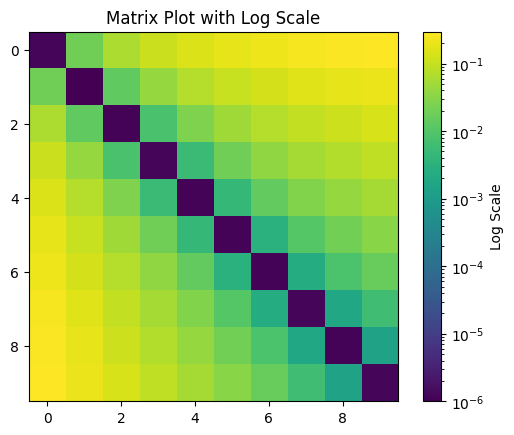

In [20]:
import matplotlib.colors as mcolors
# Plot the matrix
plt.imshow(cos_gi_list, cmap='viridis', norm=mcolors.LogNorm(vmin=cos_gi_list.min(), vmax=cos_gi_list.max()))
plt.colorbar(label="Log Scale")  # Add color bar
plt.title('Matrix Plot with Log Scale')
plt.show()

In [21]:
cos_bet_ep = np.diag(cos_gi_list, k=1)

In [22]:
cos_bet_ep

array([0.01972149, 0.01352458, 0.00799529, 0.0054944 , 0.00448869,
       0.00312071, 0.00238757, 0.00178127, 0.00138842])

In [15]:
# Data
iterations = list(range(2,epochs+1))
val_acc_list2 = val_acc_list[1:]

def plot_vali_cos_bet(iterations, val_acc_list2, cos_bet_ep):
    # Plot
    fig, ax1 = plt.subplots()

    # Validation Accuracy
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(iterations, val_acc_list2, 'o-', color='tab:blue', label='Val Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(iterations)  # Ensure iterations are displayed as integers

    # Cosine Between Epochs (Secondary Y-axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Cosine Between Epochs', color='tab:red')
    ax2.set_yscale('log')
    ax2.plot(iterations, cos_bet_ep, 's-', color='tab:red', label='Cos Between Epochs')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Titles and layout
    fig.suptitle('Model Accuracy & Cosine Between Epochs vs Iterations')
    fig.tight_layout()
    plt.show()


In [23]:
def plot_vali(iterations, val_acc_list):
    # Plot
    fig, ax1 = plt.subplots()

    # Validation Accuracy
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(iterations, val_acc_list, 'o-', color='tab:blue', label='Val Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xticks(iterations)  # Ensure iterations are displayed as integers

    # Titles and layout
    fig.suptitle('Model Accuracy vs Iterations')
    fig.tight_layout()
    plt.show()

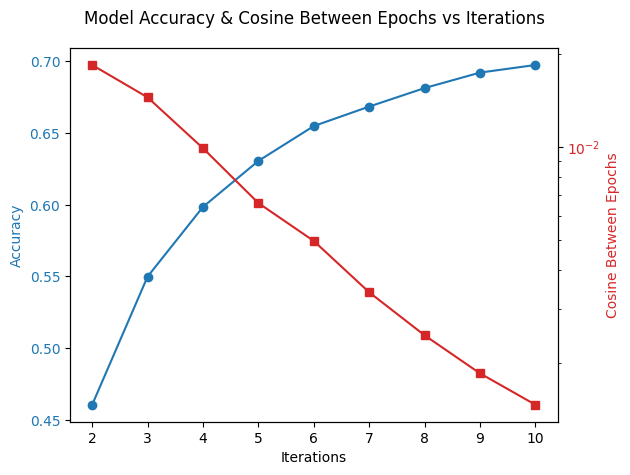

In [115]:
plot_vali_cos_bet(iterations, val_acc_list, cos_bet_ep)

In [84]:
len(val_acc_list)
val_acc_list

[0.3117, 0.4714, 0.558, 0.6031, 0.6326, 0.6493, 0.6632, 0.674, 0.683, 0.6881]

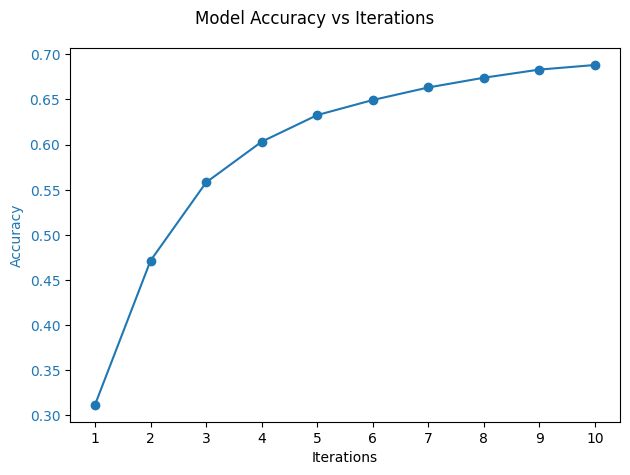

In [24]:
iterations = list(range(1,epochs+1))
plot_vali(iterations, val_acc_list)

In [92]:
model2 = model_fn().to(device) # train as malicous attack
optimizer2 = optim.SGD(model2.parameters(), lr=0.01) 

In [93]:
last_model

ConvNet(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (1): GroupNorm(128, 128, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GroupNorm(128, 128, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(128, 128, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [94]:
def weighted_avg_budget_cos(a: torch.Tensor, b: torch.Tensor, budget: float):
    """
    Compute tensor c as a weighted average of a and b such that:
        c = t * a + (1 - t) * b
    where t is in [0,1] and ensures that 1 - cos(a, c) <= budget.

    Uses binary search to find the optimal t.

    :param a: Tensor
    :param b: Tensor
    :param budget: Float, constraint on 1 - cosine similarity
    :return: Tuple (c, t)
    """
    a = a.detach().clone()
    b = b.detach().clone()
    
    def cosine_similarity(x, y):
        return torch.nn.functional.cosine_similarity(x.flatten(), y.flatten(), dim=0)
    
    left, right = 0.0, 1.0
    best_t = right
    while right - left > 1e-3:
        # print("left,right", left, right)
        mid = (left + right) / 2
        c = mid * a + (1 - mid) * b
        cos_d = 1 - cosine_similarity(a, c)

        if cos_d <= budget:
            best_t = mid  # Store valid t
            right = mid  # Try a smaller t
        else:
            left = mid  # Increase t
    
    c = best_t * a + (1 - best_t) * b
    return c, best_t*100, cos_d

In [95]:
def train_rev_w_cos(model, loader, optimizer, scheduler, epochs, model0, model1, beta, budget):    
    model.train()
    # model.parameters need to use 
    flat_grad_model0 = flat_dict(filter_trainable_state_dict(model0))
    flat_grad_model1 = flat_dict(filter_trainable_state_dict(model1))
    grad_ben = (flat_grad_model1 - flat_grad_model0).to(device)
    
    losses = []
    running_loss, samples = 0.0, 0
    print(f"data length {len(loader) * loader.batch_size}: batches {len(loader)}, batch_size {loader.batch_size}")
    
    for ep in range(epochs):
        for it, (x, y) in enumerate(loader):
            if it % 2 == 0:
                losses.append(round(eval_epoch(model, loader), 2))
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss_ce = nn.CrossEntropyLoss(reduction="mean")(model(x), y)

            # in the untraining reverse the sign of loss
            loss_ce = - loss_ce
            running_loss += loss_ce.item() * y.shape[0]
            samples += y.shape[0]
            
            # add cos loss 
            w = torch.cat([p.view(-1) for p in model.parameters()]).to(device)
            grad_mail = w - flat_grad_model0
            target = torch.ones(len(w)).to(device)
            loss_cos = nn.CosineEmbeddingLoss()(grad_ben.unsqueeze(0), grad_mail.unsqueeze(0), target)
            loss_obj = (1-beta) * loss_ce + beta * loss_cos
            loss_obj.backward()
            optimizer.step()
            scheduler.step()
            if it % 5 == 0:
                print(f"ep{ep}, loss_ce: {loss_ce:6f}, loss_cos: {loss_cos:6f}, loss_obj: {loss_obj:6f}, lr: {optimizer.param_groups[0]['lr']}")
        
        # break
        crafted_cos_d = cos_dist(grad_ben, grad_mail)
        print("eval losses", losses)
        print(f"cos_d: {crafted_cos_d}, budget: {budget}")

        if crafted_cos_d > budget:
            print(f"budget exceeded, finish training early, ep = {ep}")
            craft_g, k, cos_d2 = weighted_avg_budget_cos(a=grad_ben, 
                                                        b=grad_mail, 
                                                        budget=budget)
            print(f"crafted cos: {cos_d2}")
            crafted_cos_d = cos_dist(grad_ben, craft_g)
            restored_crafted = restore_dict_grad_flat(craft_g, model0.state_dict(), model.state_dict())
            model.load_state_dict(restored_crafted)
            
             
            print(f"crafted cos_d: {crafted_cos_d}")

            break

    return {"loss": running_loss / samples}

In [96]:
# the last iteration is the malicous attack
model1_sd = {k: v.clone().detach() for k, v in model1.state_dict().items()}
model2.load_state_dict(model1_sd)

scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=10, gamma=1)
local_loader = get_subset_dataloader(train_data, 0.03, batch_size, shuffle=True)

train_rev_w_cos(model2, local_loader, optimizer2, scheduler2, epochs=2, 
                                model0 = copy.deepcopy(last_model), 
                                model1 = model1, 
                                beta = 0.5, 
                                budget = 0.25)

data length 1824: batches 57, batch_size 32
ep0, loss_ce: -1.337632, loss_cos: 0.000000, loss_obj: -0.668816, lr: 0.01
ep0, loss_ce: -1.415784, loss_cos: 0.087182, loss_obj: -0.664301, lr: 0.01
ep0, loss_ce: -2.122214, loss_cos: 0.367936, loss_obj: -0.877139, lr: 0.01
ep0, loss_ce: -10.964849, loss_cos: 0.710711, loss_obj: -5.127069, lr: 0.01
ep0, loss_ce: -24.194002, loss_cos: 0.854067, loss_obj: -11.669968, lr: 0.01
ep0, loss_ce: -45.622971, loss_cos: 0.897513, loss_obj: -22.362728, lr: 0.01
ep0, loss_ce: -68.692215, loss_cos: 0.919731, loss_obj: -33.886242, lr: 0.01
ep0, loss_ce: -92.723907, loss_cos: 0.934346, loss_obj: -45.894779, lr: 0.01
ep0, loss_ce: -128.328278, loss_cos: 0.940530, loss_obj: -63.693874, lr: 0.01
ep0, loss_ce: -167.620438, loss_cos: 0.945390, loss_obj: -83.337524, lr: 0.01
ep0, loss_ce: -214.464478, loss_cos: 0.948368, loss_obj: -106.758057, lr: 0.01
ep0, loss_ce: -266.179352, loss_cos: 0.951122, loss_obj: -132.614120, lr: 0.01
eval losses [1.36, 1.17, 1.28, 1.

{'loss': -79.7478802257114}

In [97]:
cos = nn.CosineSimilarity(dim=0, eps=1e-9)

cos_d_model1_2 = 1- cos(flat_dict(filter_trainable_state_dict(model2)) - flat_dict(filter_trainable_state_dict(last_model)),
                          flat_dict(filter_trainable_state_dict(model1)) - flat_dict(filter_trainable_state_dict(last_model)))
print("model1_2 cos dist", cos_d_model1_2)

model1_2 cos dist tensor(0.1607, device='cuda:0')


In [98]:
model2_result = eval_op_ensemble([model2], test_loader)
print("model2_result", model2_result)

model2_result {'test_accuracy': 0.6734}


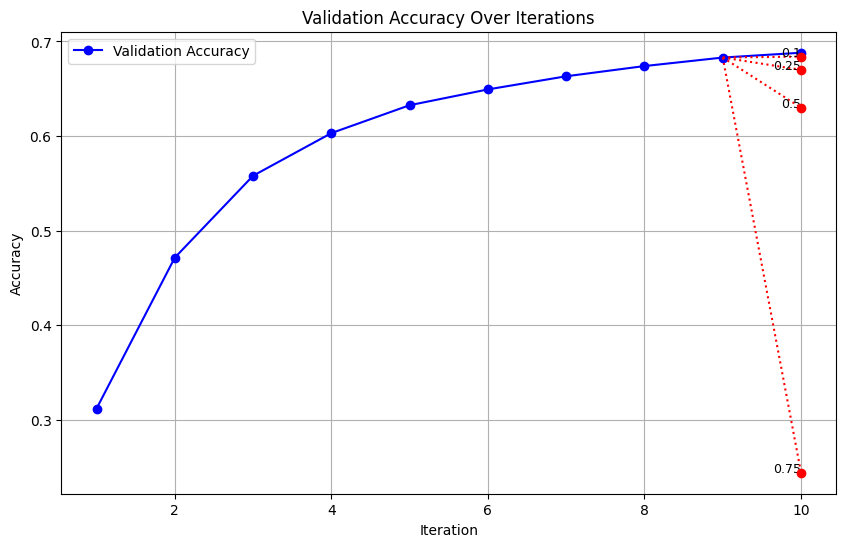

In [ ]:
import matplotlib.pyplot as plt

# Data
iterations = list(range(1, 11))
val_acc_list = [0.3117, 0.4714, 0.558, 0.6031, 0.6326, 0.6493, 0.6632, 0.674, 0.683, 0.6881]
dots_iteration_10 = [0.244, 0.63, 0.67, 0.684]
tags = [0.75, 0.5, 0.25, 0.1]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the validation accuracy
plt.plot(iterations, val_acc_list, marker='o', linestyle='-', color='b', label='Validation Accuracy')

# Plot the red dots at iteration 10
for i, (dot, tag) in enumerate(zip(dots_iteration_10, tags)):
    plt.scatter(10, dot, color='red', zorder=5)
    plt.text(10, dot, f'{tag}', fontsize=9, ha='right')

# Draw red dotted lines from iteration 10 dots to iteration 9
iteration_9_point = (9, 0.683)
for dot in dots_iteration_10:
    plt.plot([9, 10], [iteration_9_point[1], dot], linestyle=':', color='red')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Validation Accuracy Over Iterations')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()